In [18]:
from tools import analysistools as atools
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [9]:
contact23 = atools.measureLigandContact('/Users/joelforster/Projects/optidb/comparisons/hof_23_10_out.xyza')

In [10]:
contact51 = atools.measureLigandContact('/Users/joelforster/Projects/optidb/comparisons/hof_51_4_out.xyza')

In [59]:
contact29 = atools.measureLigandContact('/Users/joelforster/Projects/optidb/comparisons/hof_29_8_out.xyza')

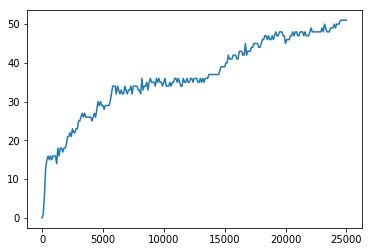

In [26]:
plt.plot([i[0] for i in contact51[0]],[i[1] for i in contact51[0]])

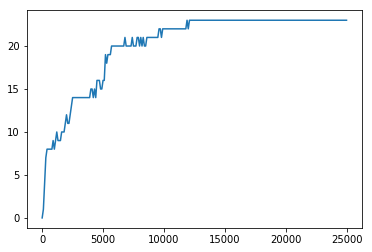

In [30]:
plt.plot([i[0] for i in contact23[0]],[i[1] for i in contact23[0]])

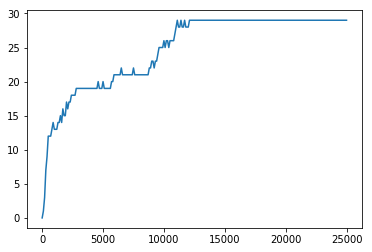

In [60]:
plt.plot([i[0] for i in contact51[0]],[i[1] for i in contact29[0]])

In [61]:
jitter51 = atools.jitterLigandContact(contact51[0],3,'full')
jitter23 = atools.jitterLigandContact(contact23[0],3,'full')
jitter29 = atools.jitterLigandContact(contact29[0],3,'full')

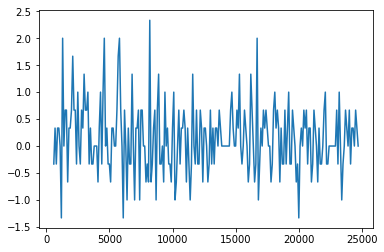

In [65]:
plt.plot(jitter51[0][3:],jitter51[1][3:])

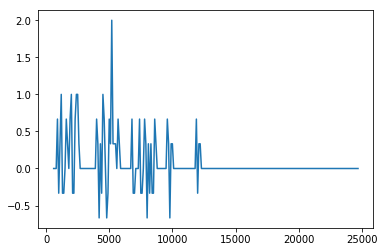

In [64]:
plt.plot(jitter23[0][3:],jitter23[1][3:])

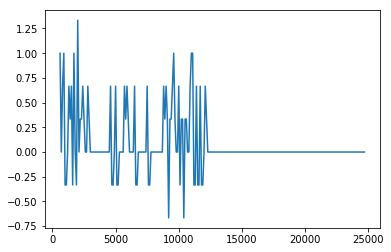

In [66]:
plt.plot(jitter29[0][3:],jitter29[1][3:])

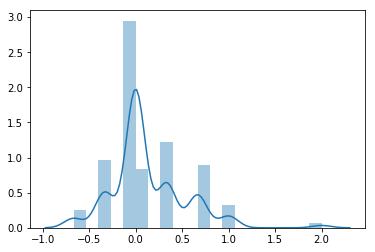

In [72]:
sns.distplot(jitter23[1][3:120])

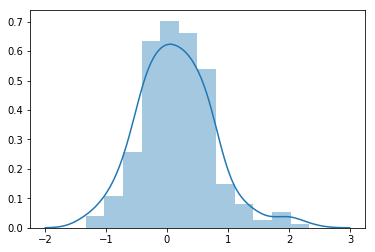

In [70]:
sns.distplot(jitter51[1][3:])

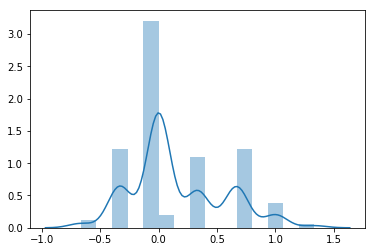

In [73]:
sns.distplot(jitter29[1][3:120])